# Example 04: PyTorch CNN

## 事前準備

In [1]:
import torch

# GPUが使えるか確認してデバイスを設定
# NOTE: `x = x.to(device) ` とすることで対象のデバイスに切り替え可能
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## CNN

In [2]:
import torch
import torchinfo
from torch import nn
from torch import optim
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

### DataLoader設定

In [3]:
# transformを準備
affine = transforms.RandomAffine((-30, 30), scale=(0.8, 1.2))
flip = transforms.RandomHorizontalFlip(p=0.5)
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # 平均0、標準偏差1

transform_train = transforms.Compose([
    affine,
    flip,
    transforms.ToTensor(),
    normalize
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [4]:
# DataLoader作成
cifar10_train = CIFAR10(root='../cache/data', train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10(root='../cache/data', train=False, download=True, transform=transform_test)
cifar10_classes = cifar10_train.classes

In [5]:
# DataLoaderの設定
batch_size = 128
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

In [6]:
len(cifar10_train), len(cifar10_test)

(50000, 10000)

### モデル構築

In [7]:
class Net(nn.Module):
    def __init__(self, n_classes: int):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)         # 入力チャネル、出力チャネル、フィルタ数
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)          # 領域のサイズ、領域の間隔
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 256)
        self.dropout = nn.Dropout(0.5)          # ドロップアウト率
        self.fc2 = nn.Linear(256, n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        入力画像: (3, 32, 32)
        conv1   : (8, 28, 28)
        pool    : (8, 14, 14)
        conv2   : (16, 10, 10)
        pool    : (16, 5, 5)
        fc1     : (256)
        fc2     : (10)
        """
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [8]:
net = Net(len(cifar10_classes))

In [9]:
torchinfo.summary(net, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [1, 8, 28, 28]            608
├─ReLU: 1-2                              [1, 8, 28, 28]            --
├─MaxPool2d: 1-3                         [1, 8, 14, 14]            --
├─Conv2d: 1-4                            [1, 16, 10, 10]           3,216
├─ReLU: 1-5                              [1, 16, 10, 10]           --
├─MaxPool2d: 1-6                         [1, 16, 5, 5]             --
├─Linear: 1-7                            [1, 256]                  102,656
├─ReLU: 1-8                              [1, 256]                  --
├─Dropout: 1-9                           [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 109,050
Trainable params: 109,050
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.90
Input size (MB): 0.01
Forward/b

### 学習

In [10]:
%%time
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

record_loss_train = []
record_loss_test = []

n_epochs = 20
verbose = 1

for epoch in tqdm(range(n_epochs)):
    net.train()
    loss_train = 0.0

    for (x, t) in tqdm(train_loader):
        x, t = x.to(device), t.to(device)
        y = net(x)

        loss = loss_func(y, t)
        loss_train += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_train /= len(train_loader)
    record_loss_train.append(loss_train)

    net.eval()
    loss_test = 0.0

    for (x, t) in tqdm(test_loader):
        x, t = x.to(device), t.to(device)
        y = net(x)

        loss = loss_func(y, t)
        loss_test += loss.item()

    loss_test /= len(test_loader)
    record_loss_test.append(loss_test)

    if epoch % verbose == 0:
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_test: {loss_test:.4f}')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 1, loss_train: 1.8606, loss_test: 1.6016


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 2, loss_train: 1.6261, loss_test: 1.4700


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 3, loss_train: 1.5549, loss_test: 1.4004


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 4, loss_train: 1.5087, loss_test: 1.3492


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 5, loss_train: 1.4786, loss_test: 1.3270


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 6, loss_train: 1.4551, loss_test: 1.3255


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 7, loss_train: 1.4312, loss_test: 1.2835


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 8, loss_train: 1.4095, loss_test: 1.2530


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 9, loss_train: 1.3920, loss_test: 1.2564


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 10, loss_train: 1.3776, loss_test: 1.2979


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 11, loss_train: 1.3691, loss_test: 1.2382


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 12, loss_train: 1.3529, loss_test: 1.2507


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 13, loss_train: 1.3441, loss_test: 1.2163


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 14, loss_train: 1.3306, loss_test: 1.2284


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 15, loss_train: 1.3246, loss_test: 1.1771


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 16, loss_train: 1.3126, loss_test: 1.1593


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 17, loss_train: 1.3098, loss_test: 1.1911


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 18, loss_train: 1.2903, loss_test: 1.1491


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 19, loss_train: 1.2961, loss_test: 1.1703


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 20, loss_train: 1.2896, loss_test: 1.1249
CPU times: user 2min 43s, sys: 3.9 s, total: 2min 46s
Wall time: 2min 44s


### 誤差の推移

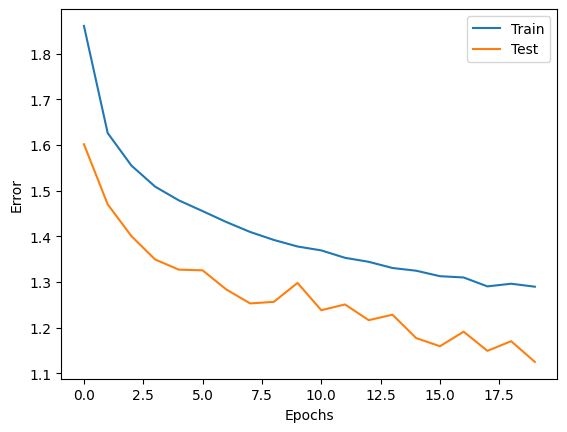

In [11]:
plt.plot(range(len(record_loss_train)), record_loss_train, label='Train')
plt.plot(range(len(record_loss_test)), record_loss_test, label='Test')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

### 正解率算出

In [12]:
correct = 0
total = 0

net.eval()

for j, (x, t) in enumerate(test_loader):
    x, t = x.to(device), t.to(device)
    y = net(x)

    correct += (y.argmax(1) == t).sum().item()
    total += len(x)

print(f"accuracy: {correct / total}")

accuracy: 0.6039


### 訓練済みモデルを使用した予測

In [13]:
def get_sample_image() -> tuple[torch.Tensor, torch.Tensor]:
    cifar10_test = CIFAR10(root='../cache/data', train=False, download=True, transform=transform_test)
    cifar10_loader = DataLoader(cifar10_test, batch_size=1, shuffle=True)

    images, labels = next(iter(cifar10_loader))

    select_index = 0
    return images[select_index], labels[select_index]

def show_image(image: torch.Tensor) -> None:
    plt.imshow(image.permute(1, 2, 0))
    # ラベルとメモリを非表示に設定
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
    plt.show()

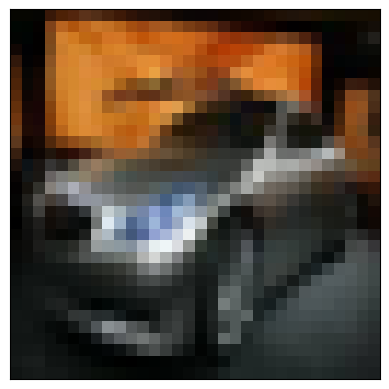

answer: automobile, predict: automobile


In [14]:
image, label = get_sample_image()
show_image(image)

net.eval()
image, label = image.to(device), label.to(device)
y = net(image)

print(f"answer: {cifar10_classes[label]}, predict: {cifar10_classes[y.argmax().item()]}")